In [14]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import llops as yp
import llops.simulation as sim
import llops.operators as ops
import numpy as np

yp.setDefaultBackend('numpy')
yp.setDefaultDatatype('complex32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Object

In [15]:
x_even = yp.simulation.cameraman(shape=(100, 100))
x_odd = yp.simulation.cameraman(shape=(101, 101))

# Define image size for other tests
image_size = [64, 128]

# Load object and crop to size
x = sim.brain(image_size)

## Check Equality of numpy and arrayfire backends

<IPython.core.display.Javascript object>


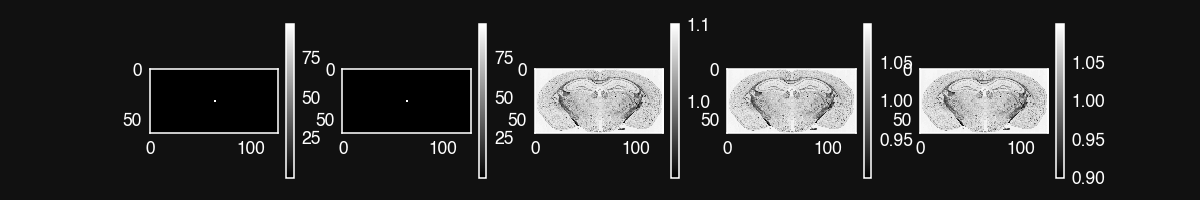

In [42]:
try:
    import arrayfire
    sz = yp.shape(x)
    F_af = ops.FourierTransform(sz, center=True, backend='arrayfire',  normalize=False)
    F_np = ops.FourierTransform(sz, center=True, backend='numpy', normalize=True)

    plt.figure(figsize=(12,2))
    plt.subplot(151)
    plt.imshow(yp.abs(yp.changeBackend(F_af * yp.changeBackend(x, 'arrayfire'), 'numpy')))
    plt.colorbar()

    plt.subplot(152)
    plt.imshow(yp.abs(F_np * yp.changeBackend(x, 'numpy')))
    plt.colorbar()
    
    plt.subplot(153)
    plt.imshow(yp.abs(yp.changeBackend(F_af.H * F_af * yp.changeBackend(x, 'arrayfire'), 'numpy')))
    plt.colorbar()

    plt.subplot(154)
    plt.imshow(yp.abs(F_np.H * F_np * yp.changeBackend(x, 'numpy')))
    plt.colorbar()
    
    plt.subplot(155)
    plt.imshow(yp.changeBackend(yp.abs(x), 'numpy'))
    plt.colorbar()
except ModuleNotFoundError:
    pass

## FFT Test

In [44]:
# Define backend - valid options are 'scipy', 'numpy', and 'fftw'

# Define "true" FFTs
Ft = lambda x: np.fft.fftshift(np.fft.fft2(np.fft.fftshift(x, axes=(0, 1)), axes=(0, 1), norm='ortho'), axes=(0, 1))
iFt = lambda x: np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(x, axes=(0, 1)), axes=(0, 1), norm='ortho'), axes=(0, 1))

eps_fft = yp.precision(x, for_sum=True) * 10

if yp.config.default_backend == 'numpy':
    fft_backends = ['scipy', 'numpy']
else:
    fft_backends = ['af']

for fft_backend in fft_backends:
    
    # Create Operator
    F = ops.FourierTransform(image_size, axes=(0, 1), fft_backend=fft_backend, center=True, normalize=True)
    
    # Check forward model
    assert yp.sum(yp.abs(Ft(x).reshape(image_size) - yp.changeBackend(F * x, 'numpy').reshape(image_size))) < eps_fft, '%f' % yp.sum(yp.abs(Ft(x).reshape(image_size) - yp.changeBackend(F * vec(x), 'numpy').reshape(image_size)))
    assert yp.sum(yp.abs(iFt(x).reshape(image_size) - yp.changeBackend((F.H * x), 'numpy').reshape(image_size))) < eps_fft
    
    # Check reciprocity
    assert yp.sum(yp.abs(F * F.H * x - x)) < eps_fft, "%.4e" % yp.sum(yp.abs(F * F.H * vec(x) - vec(x)))

    # Check Gradient
    F.gradient_check()
    
# Render forward model
F.latex()

# Render gradient
F.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Ensure FFT is Unitary for Even and Odd array sizes

In [45]:
yp.assert_equality(x_even, yp.iFt(yp.Ft(x_even)))
yp.assert_equality(x_odd, yp.iFt(yp.Ft(x_odd)))

# Ensure Centering is Correct

In [46]:
test_even = yp.zeros((100,100))
test_even[50,50] = 1
test_odd = yp.zeros((101,101))
test_odd[51,51] = 1

assert yp.sum(yp.abs(yp.angle(yp.Ft(test_even)))) < 1e-2
assert yp.sum(yp.abs(yp.angle(yp.Ft(test_odd))))  < 1e-2